# Анализ и прогнозирование временного ряда.

Цель лабораторной работы: изучение основных методов анализа и прогнозирование временных рядов.


    1) Выберите набор данных (датасет) для решения задачи прогнозирования временного ряда.
    2) Визуализируйте временной ряд и его основные характеристики.
    3) Разделите временной ряд на обучающую и тестовую выборку.
    4) Произведите прогнозирование временного ряда с использованием как минимум двух методов.
    5) Визуализируйте тестовую выборку и каждый из прогнозов.
    6) Оцените качество прогноза в каждом случае с помощью метрик.


## 1) Выберите набор данных (датасет) для решения задачи прогнозирования временного ряда.

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score

from datetime import date


import statsmodels.api as sm




from matplotlib import pyplot
import matplotlib.pyplot as plt

# скроем предупреждения о возможных ошибках для лучшей читаемости
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./currency_exchange_rates_02-01-1995_-_02-05-2018.csv')

In [3]:
df.dtypes

Date                           object
Algerian Dinar                float64
Australian Dollar             float64
Bahrain Dinar                 float64
Bolivar Fuerte                float64
Botswana Pula                 float64
Brazilian Real                float64
Brunei Dollar                 float64
Canadian Dollar               float64
Chilean Peso                  float64
Chinese Yuan                  float64
Colombian Peso                float64
Czech Koruna                  float64
Danish Krone                  float64
Euro                          float64
Hungarian Forint              float64
Icelandic Krona               float64
Indian Rupee                  float64
Indonesian Rupiah             float64
Iranian Rial                  float64
Israeli New Sheqel            float64
Japanese Yen                  float64
Kazakhstani Tenge             float64
Korean Won                    float64
Kuwaiti Dinar                 float64
Libyan Dinar                  float64
Malaysian Ri

In [4]:
df.shape

(2978, 52)

In [5]:
df.describe()

,Algerian Dinar,Australian Dollar,Bahrain Dinar,Bolivar Fuerte,Botswana Pula,Brazilian Real,Brunei Dollar,Canadian Dollar,Chilean Peso,Chinese Yuan,...,South African Rand,Sri Lanka Rupee,Swedish Krona,Swiss Franc,Thai Baht,Trinidad And Tobago Dollar,Tunisian Dinar,U.A.E. Dirham,U.K. Pound Sterling,U.S. Dollar
count,0.0,2846.000000,2.948000e+03,0.0,1887.000000,2676.000000,1910.000000,2785.000000,1902.000000,1881.000000,...,2663.000000,2720.000000,2790.000000,2837.000000,2683.000000,2568.000000,0.0,2949.000000,2911.000000,2978.0
mean,NaN,0.670354,3.760000e-01,NaN,0.299010,1.939318,1.717508,1.412722,568.992434,8.253424,...,6.394235,79.045812,8.156801,1.412337,37.277911,6.195019,NaN,3.672109,1.625574,1.0
std,NaN,0.091659,5.552057e-17,NaN,0.668351,0.816010,0.062274,0.118059,79.590357,0.071618,...,1.970454,18.622141,1.126076,0.180703,7.036977,0.133683,NaN,0.000659,0.127571,0.0
min,NaN,0.483300,3.760000e-01,NaN,0.132750,0.832000,1.000000,1.099000,377.500000,7.997600,...,3.530000,49.570000,6.448500,1.123600,24.440000,5.839300,NaN,3.671000,1.374700,1.0
25%,NaN,0.592800,3.760000e-01,NaN,0.178450,1.093300,1.677700,1.353900,513.500000,8.276600,...,4.700000,60.122500,7.367200,1.259200,36.225000,6.179100,NaN,3.671000,1.546800,1.0
50%,NaN,0.675100,3.760000e-01,NaN,0.194200,1.886900,1.717000,1.409800,540.610000,8.277000,...,6.185000,77.540000,7.868750,1.394900,39.475000,6.264050,NaN,3.672500,1.613000,1.0
75%,NaN,0.751800,3.760000e-01,NaN,0.215600,2.655125,1.752950,1.510900,619.947500,8.277500,...,7.397500,96.940000,8.673750,1.530300,42.049500,6.275900,NaN,3.672500,1.684400,1.0
max,NaN,0.820300,3.760000e-01,NaN,4.841400,3.954400,1.851000,1.613200,758.210000,8.746000,...,13.544500,105.473300,10.995000,1.822800,56.061000,6.327900,NaN,3.672500,1.951200,1.0


In [6]:
selected_columns = df[["Date","Russian Ruble"]]

new_df = selected_columns.copy()

print(new_df)

           Date  Russian Ruble
0      1995-1-2            NaN
1      1995-1-3            NaN
2      1995-1-4            NaN
3      1995-1-5            NaN
4      1995-1-6            NaN
...         ...            ...
2973  2006-6-15        27.0369
2974  2006-6-16        26.9869
2975  2006-6-19        27.0379
2976  2006-6-20        27.0450
2977  2006-6-21        27.0163

[2978 rows x 2 columns]


In [7]:
df = new_df[df['Russian Ruble'].notna()]

In [8]:
print(new_df)

           Date  Russian Ruble
0      1995-1-2            NaN
1      1995-1-3            NaN
2      1995-1-4            NaN
3      1995-1-5            NaN
4      1995-1-6            NaN
...         ...            ...
2973  2006-6-15        27.0369
2974  2006-6-16        26.9869
2975  2006-6-19        27.0379
2976  2006-6-20        27.0450
2977  2006-6-21        27.0163

[2978 rows x 2 columns]


In [9]:
df.isnull().sum()

Date             0
Russian Ruble    0
dtype: int64

## 2) Визуализируйте временной ряд и его основные характеристики.

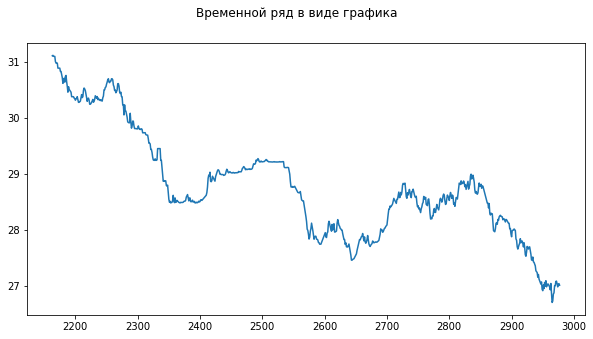

In [10]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
df.plot(ax=ax, legend=False)
pyplot.show()

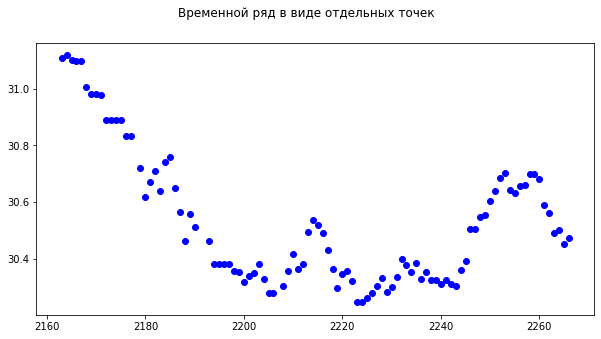

In [11]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде отдельных точек')
df[:100].plot(ax=ax, legend=False, style='bo')
pyplot.show()

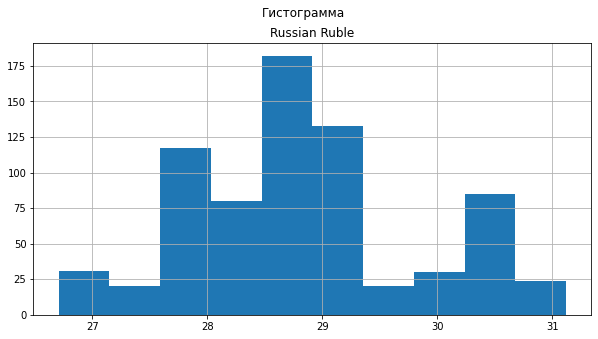

In [12]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Гистограмма')
df.hist(ax=ax, legend=False)
pyplot.show()

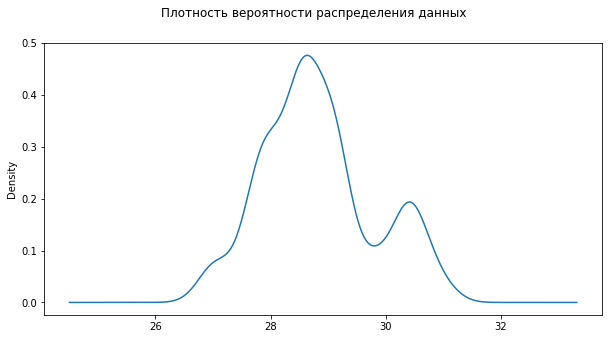

In [13]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
df.plot(ax=ax, kind='kde', legend=False)
pyplot.show()

In [14]:
df.shape

(722, 2)

In [15]:
df_Rubles = df[["Russian Ruble"]]

df_Rubles = df_Rubles.copy()

df_Rubles.shape

(722, 1)


#### Lag Plots

Диаграмма позволяет понять автокорреляцию в данных временного ряда. Может рассматриваться (хотя это весьма грубое сравнение) как аналог корреляционной матрицы для временного ряда.
По оси абсцисс откладывается значение временного ряда.
По оси ординат для каждой точки откладывается ее лаг порядка i, где i - параметр, задаваемый пользователем.

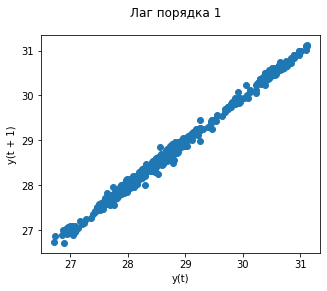

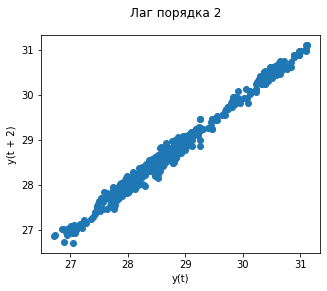

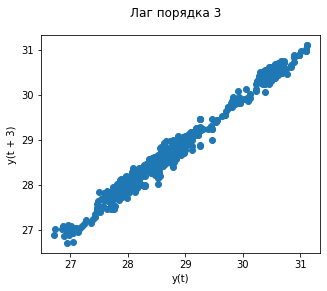

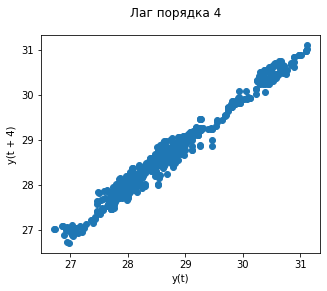

In [16]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(df_Rubles, lag=i, ax=ax)
    pyplot.show()

Если облако точек направлено из левого нижнего угла в правый верхний, то имеет место положительная автокорреляция.

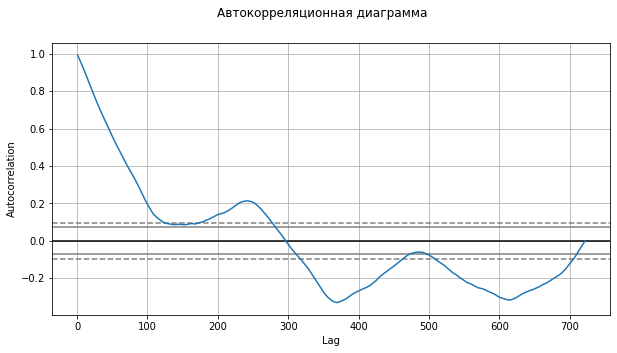

In [17]:
# По оси Y откладывается ковариация 
# https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show

fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(df_Rubles, ax=ax)
pyplot.show()


#### Автокорреляционная функция

Показывает зависимость коэффициента корреляции от лага, то есть корреляцию между исходным временным рядом и временным рядом,сдвинутым на заданный лаг.


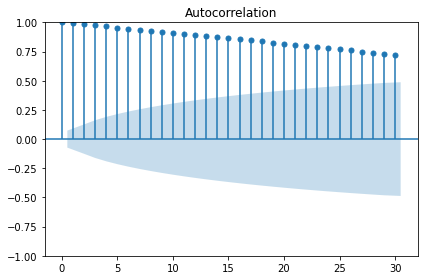

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_Rubles, lags=30)
plt.tight_layout()

#### Частичная автокорреляционная функция

Находит корреляцию остатков, которые остается после удаления эффектов, объясняемых более ранними лагами.

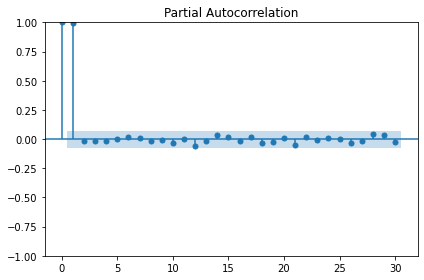

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_Rubles, lags=30)
plt.tight_layout()